# Partial Directed Coherence 



## Background

(1) MAR model (N time series):

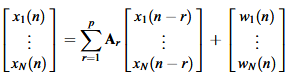   

wherer Ar is coefficient matrix

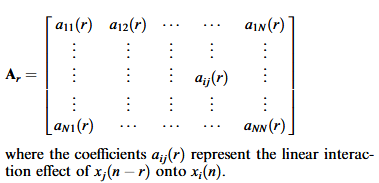

(2) The partial directed coherence PDC) from j to i is given below.

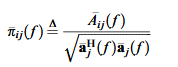



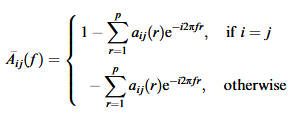


## 1. Generate simulated data for N time series 

Example. We will use an example network from Baccala & Sameshima 2001.
Suppose that simulated signal generator was generated by the equations:

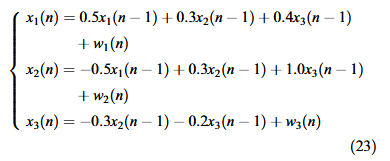

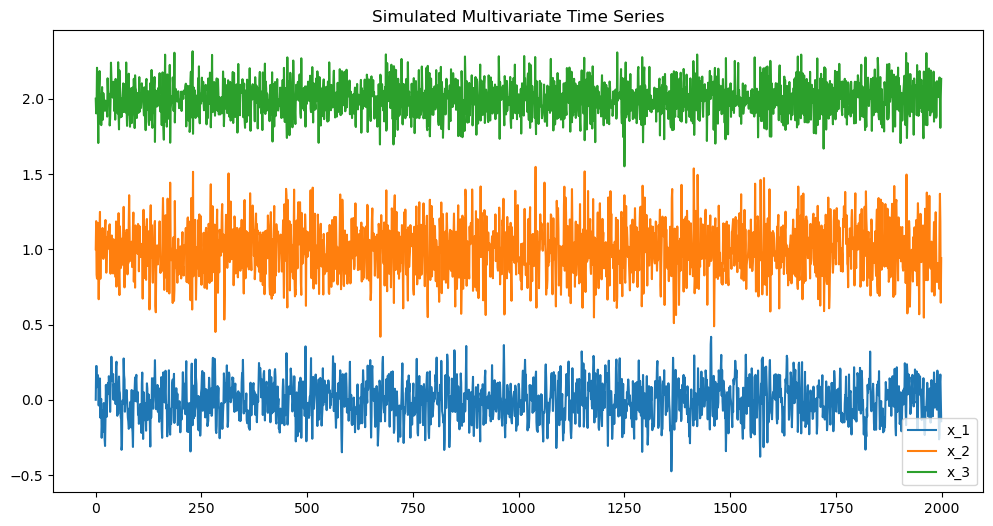

In [4]:
# Method: multivariate autoregressive (MVAR) modelling
# Author: Hanwei Liu <violalhw@gmail.com>
# Date: 2025-04-04

import numpy as np
import matplotlib.pyplot as plt

def generate_mvar_data(A, n_channels, n_samples, noise_std=0.1):
    np.random.seed(0)
    w = np.random.normal(0, noise_std, (n_samples, n_channels)) # "zero-mean uncorrelated white processes with identical variances."
    # w = np.random.randn(n_samples, n_channels)
    
    X = np.zeros((n_samples, n_channels))

    for t in range(1, n_samples):
        for i in range(A.shape[0]):
            X[t] += X[t - i - 1] @ A[i].T
            
        X[t] += w[t]

    return X


# Initialization of model parameters
n_channels = 3
n_samples = 2000  # sample points
n_lags = 1        # lag order
A = np.zeros((n_lags, n_channels, n_channels))

# Assume x_3 is not influenced explicity by the past state of x_1: x(3,1) = 0.0 in math
A[0] = np.array([
    [0.5, 0.3, 0.4],
    [-0.5, 0.3, 1.0],
    [0.0, -0.3, -0.2]
])


X = generate_mvar_data(A, n_channels, n_samples) # X.shape = (n_samples, n_channels)


# Visualization
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(X[:, i] + i*1, label=f'x_{i+1}')
plt.title("Simulated Multivariate Time Series")
plt.legend()
plt.show()

## 2. Estimating VAR model coefficients


In [9]:
from statsmodels.tsa.api import VAR

# Create VAR model, and estimated Ar is calculated by Akaike information criterion (AIC)
model = VAR(X)
results = model.fit(maxlags=n_lags, ic='aic')

A_estimated = results.coefs
print("Estimated Ar matrix:\n", A_estimated)

# Defined Ar:
#  [0.5, 0.3, 0.4],
#  [-0.5, 0.3, 1.0],
#  [0.0, -0.3, -0.2]

Estimated Ar matrix:
 [[[ 0.48519583  0.28575892  0.4062904 ]
  [-0.4983048   0.30698827  1.02539053]
  [-0.01899148 -0.29593055 -0.21000126]]]


## 3. Compute PDC at a certain frequency


In [19]:
def compute_pdc(A, freqs, n_channels):
    """
    Computes Partial Directed Coherence (PDC) from MVAR coefficients.

    Parameters:
    - A: numpy array of shape (n_lags, n_channels, n_channels), MVAR coefficients
    - freqs: numpy array of frequency values (0 to 0.5 for normalized freq)
    - n_channels: number of channels (variables)

    Returns:
    - PDC: array of shape (n_channels, n_channels, len(freqs)), squared PDC values
    """
    n_freqs = len(freqs)
    PDC = np.zeros((n_channels, n_channels, n_freqs), dtype=complex)

    p = A.shape[0]  # model order = n_lags

    for fi, f in enumerate(freqs):
        z = np.exp(-1j * 2 * np.pi * f)
        A_f = np.sum([(z ** (-r - 1)) * A[r] for r in range(p)], axis=0)
        Abar_f = np.eye(n_channels) - A_f

        for j in range(n_channels):
            aj = Abar_f[:, j]
            denominator = np.sqrt(np.conj(aj).T @ aj)
            for i in range(n_channels):
                PDC[i, j, fi] = Abar_f[i, j] / denominator if denominator != 0 else 0

    return np.abs(PDC)**2


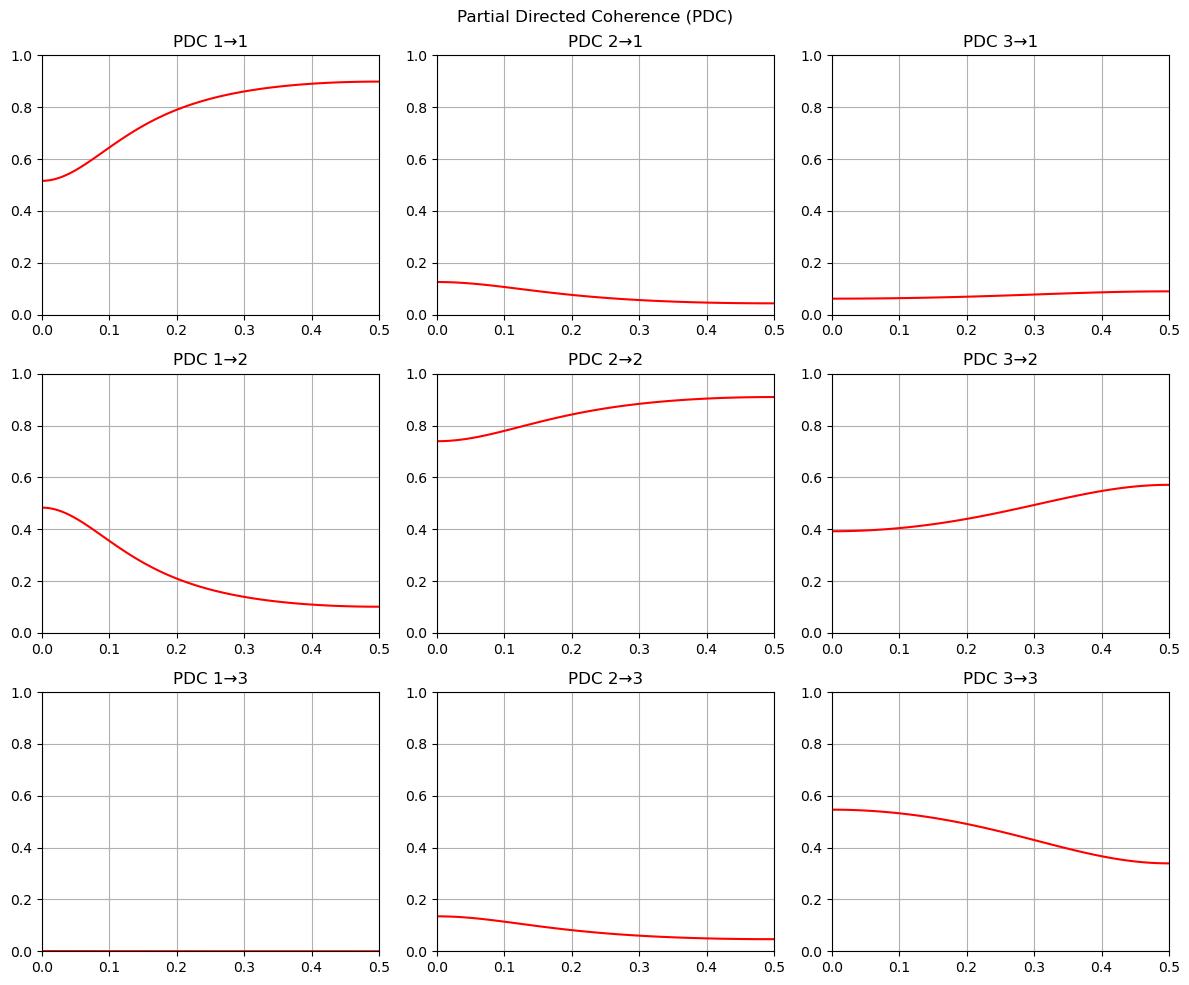

In [22]:
freqs = np.linspace(0, 0.5, 100)

PDC_values = compute_pdc(A_estimated, freqs, n_channels)

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle("Partial Directed Coherence (PDC)")

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(freqs, PDC_values[i, j, :], 'r')
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 1)
        ax.set_title(f"PDC {j+1}→{i+1}")
        ax.grid(True)

plt.tight_layout()
plt.show()

# Reference

[[1]](https://link.springer.com/article/10.1007/pl00007990) Baccalá, L. A., & Sameshima, K. (2001). Partial directed coherence: a new concept in neural structure determination. Biological cybernetics, 84(6), 463-474.